In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
from ingest.ohlcv import get_connection

In [2]:
with get_connection() as conn:
    df = pd.read_sql("SELECT * FROM ohlcv", conn)

df = df[df["ticker"] == "BBVA.MC"]
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.asfreq("B")
df["close"] = df["close"].ffill()
df.head(1)
prices = df["close"]
log_returns = np.log(prices).diff().dropna()

This is the continuation of arima/log-returns. Previously, we assumed constant variance, which is unrealistic. Using a GARCH model allows us to capture time-varying volatility and obtain more reliable forecasts and uncertainty estimates.

In [3]:
p,d,q = 0,0,0
model = ARIMA(log_returns, order=(p,d,q))
model_fit = model.fit()

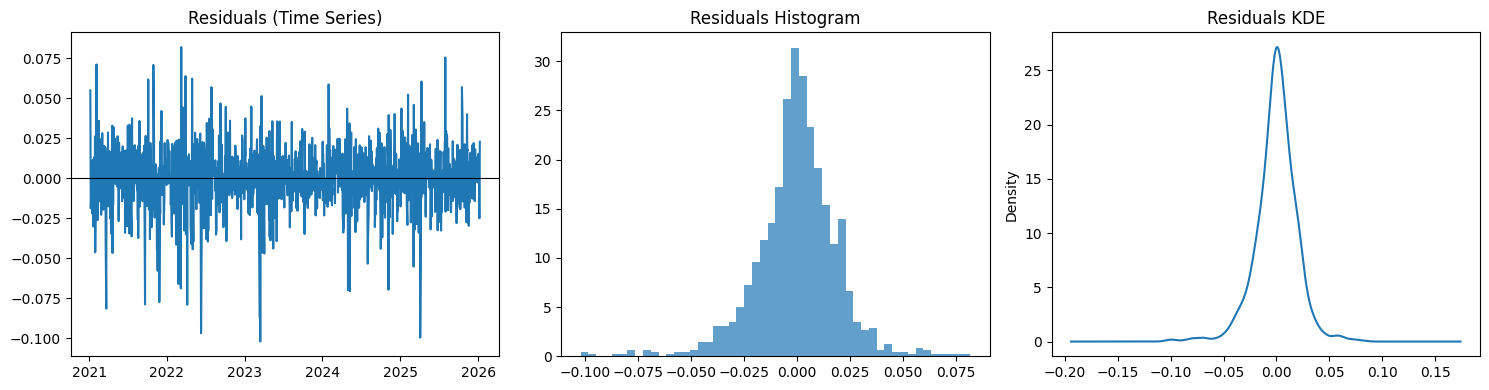

In [4]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(residuals)
axes[0].set_title("Residuals (Time Series)")
axes[0].axhline(0, color="black", linewidth=0.8)

axes[1].hist(residuals, bins=50, density=True, alpha=0.7)
axes[1].set_title("Residuals Histogram")

residuals.plot(kind="kde", ax=axes[2])
axes[2].set_title("Residuals KDE")

plt.tight_layout()
plt.show()


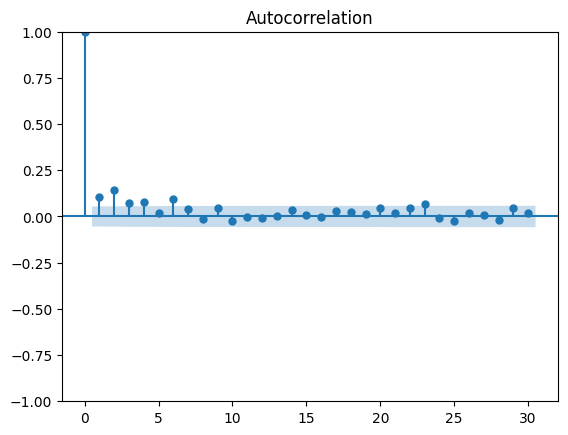

In [5]:
plot_acf(residuals**2, lags=30)
plt.show()

There is significant autocorrelation in squared residuals, indicating volatibility clustering.

In [6]:
arch_test = het_arch(residuals)
arch_test


(np.float64(58.977913362289875),
 np.float64(5.6544229891296016e-09),
 6.1261679929569715,
 3.5718425494600313e-09)

The Autoregressive Conditional Heteroskedasticity (ARCH) test confirms that there is heteroskedasticity. We will use GARCH(1,1) to capture time-varying volatibility. 

wE CHOSEskewt over t or normal as the standardized residuals match better this distributions (fat tails + asyymetric) lower negloglikehood

In [ ]:
# PUT BACK TO NORMAL PREDICTIONS LATER!!!!!!!!!!!!!!
scaled_returns = log_returns*100
garch = arch_model(
    scaled_returns,
    mean='Constant',   # ARIMA
    vol='GARCH',
    p=1,
    q=1,
    dist='skewt'      # luego puedes probar 't' normak skewt
)

garch_fit = garch.fit(update_freq=5)
print(garch_fit.summary())


Iteration:      5,   Func. Count:     36,   Neg. LLF: 2678.120430554115
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2678.1199034267065
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2678.12
Distribution:                  Normal   AIC:                           5364.24
Method:            Maximum Likelihood   BIC:                           5384.94
                                        No. Observations:                 1308
Date:                Thu, Jan 15 2026   Df Residuals:                     1307
Time:                        21:29:18   Df Model:                            1
         

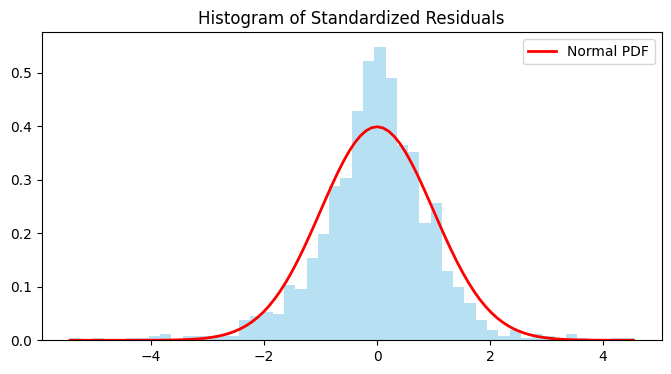

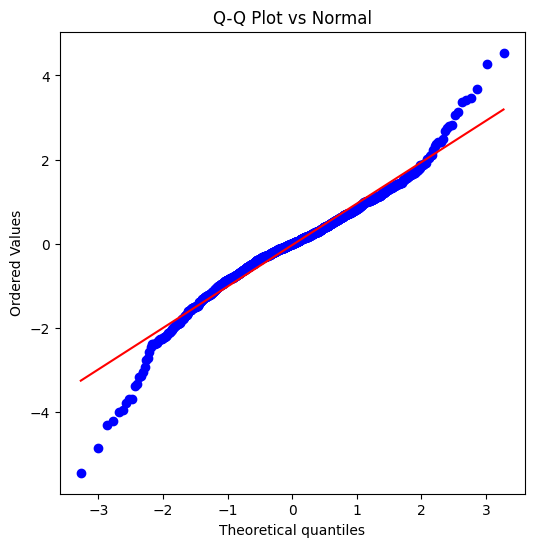

Jarque-Bera test statistic: 509.3404916765025
p-value: 2.501022089410564e-111
Log-likelihood of t fit: -1787.6862664250802


In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Standardized residuals
std_resid = garch_fit.std_resid

# 1. Histogram
plt.figure(figsize=(8,4))
plt.hist(std_resid, bins=50, density=True, alpha=0.6, color='skyblue')
x = np.linspace(min(std_resid), max(std_resid), 100)
plt.plot(x, stats.norm.pdf(x), 'r', lw=2, label='Normal PDF')
plt.title("Histogram of Standardized Residuals")
plt.legend()
plt.show()

# 2. Q-Q plot against normal
plt.figure(figsize=(6,6))
stats.probplot(std_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot vs Normal")
plt.show()

# 3. Jarque-Bera test for normality
from scipy.stats import jarque_bera
jb_stat, jb_p = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_stat)
print("p-value:", jb_p)

# 4. Optional: compare fit with t-distribution
from scipy.stats import t
params_t = t.fit(std_resid)
loglik_t = np.sum(t.logpdf(std_resid, *params_t))
print("Log-likelihood of t fit:", loglik_t)

# You can also compare AIC/BIC manually if needed


In [23]:
res = garch.fit(update_freq=5)
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(res.std_resid, lags=10)
acorr_ljungbox(res.std_resid**2, lags=10)


Iteration:      5,   Func. Count:     36,   Neg. LLF: 2678.120430554115
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2678.1199034267065
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8


,lb_stat,lb_pvalue
1,0.033273,0.855262
2,0.138038,0.933309
3,0.160671,0.983674
4,0.283430,0.990859
5,1.244064,0.940581
6,3.130527,0.792295
7,3.318679,0.854041
8,4.572251,0.802162
9,4.600282,0.867669
10,6.976318,0.727679


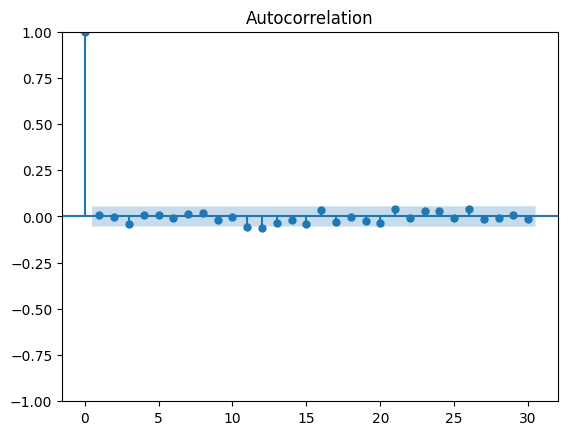

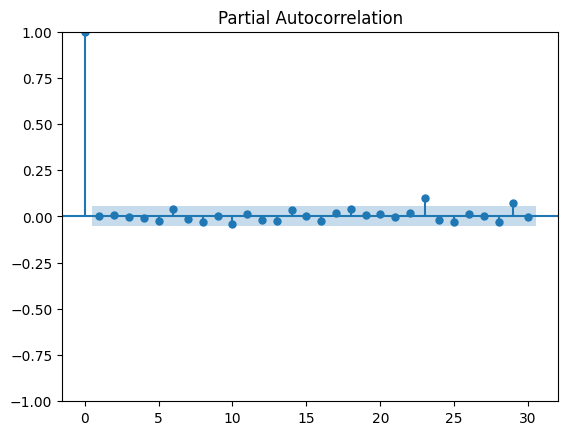

In [26]:
std_resid = garch_fit.std_resid
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(std_resid, lags=30)
plt.show()

plot_pacf(std_resid**2, lags=30)
plt.show()


In [23]:
from statsmodels.stats.diagnostic import het_arch
het_arch(std_resid)


(np.float64(1238.1821342925543),
 np.float64(8.351859748729976e-260),
 2962.2859140973796,
 0.0)

In [17]:
rmse_price = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (Price): {rmse_price:.4f} €")


NameError: name 'test' is not defined

2.5 Respuesta corta si te preguntan oralmente

ARCH modela la volatilidad solo con shocks pasados, mientras que GARCH introduce persistencia explícita mediante la varianza retardada, lo que permite capturar clustering de volatilidad con menos parámetros. Por eso GARCH(1,1) es el baseline en finanzas.

In [13]:
forecast = garch_fit.forecast(horizon=10)

variance_forecast = forecast.variance.iloc[-1]
volatility_forecast = variance_forecast ** 0.5


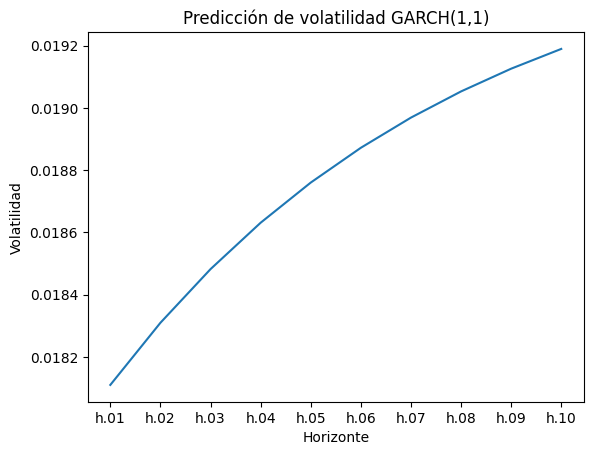

In [14]:
import matplotlib.pyplot as plt

plt.plot(volatility_forecast)
plt.title("Predicción de volatilidad GARCH(1,1)")
plt.ylabel("Volatilidad")
plt.xlabel("Horizonte")
plt.show()


In [21]:
train_size = int(len(log_returns)-7) 
train = log_returns.iloc[:train_size] 
test = log_returns.iloc[train_size:] 
p,d,q = 0,0,0 
op_model = ARIMA(train, order=(p,d,q)) 
op_model_fit = op_model.fit() 
forecast = op_model_fit.forecast(steps=len(test)) 
last_train_price = prices.iloc[train_size-1] 
price_forecast = last_train_price * np.exp(forecast.cumsum()) 
test_prices = prices.iloc[train_size:] 
train_prices = prices.iloc[:train_size] 
zoom_window = 33

In [ ]:

garch = arch_model(
    train,
    mean='Constant',
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'
)

garch_fit = garch.fit(disp="off")


c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003779. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [23]:
horizon = len(test)

garch_forecast = garch_fit.forecast(horizon=horizon)

# Varianza y volatilidad
variance_fc = garch_forecast.variance.iloc[-1]
sigma_fc = np.sqrt(variance_fc)


In [24]:
z = 1.96  # 95%

ret_mean = forecast
ret_upper = forecast + z * sigma_fc.values
ret_lower = forecast - z * sigma_fc.values


In [26]:
plot_start = train_size - zoom_window
zoom_train_prices = prices.iloc[plot_start:train_size] 
zoom_test_prices = prices.iloc[train_size:]

In [28]:
price_forecast = last_train_price * np.exp(ret_mean.cumsum())
price_upper = last_train_price * np.exp(ret_upper.cumsum())
price_lower = last_train_price * np.exp(ret_lower.cumsum())


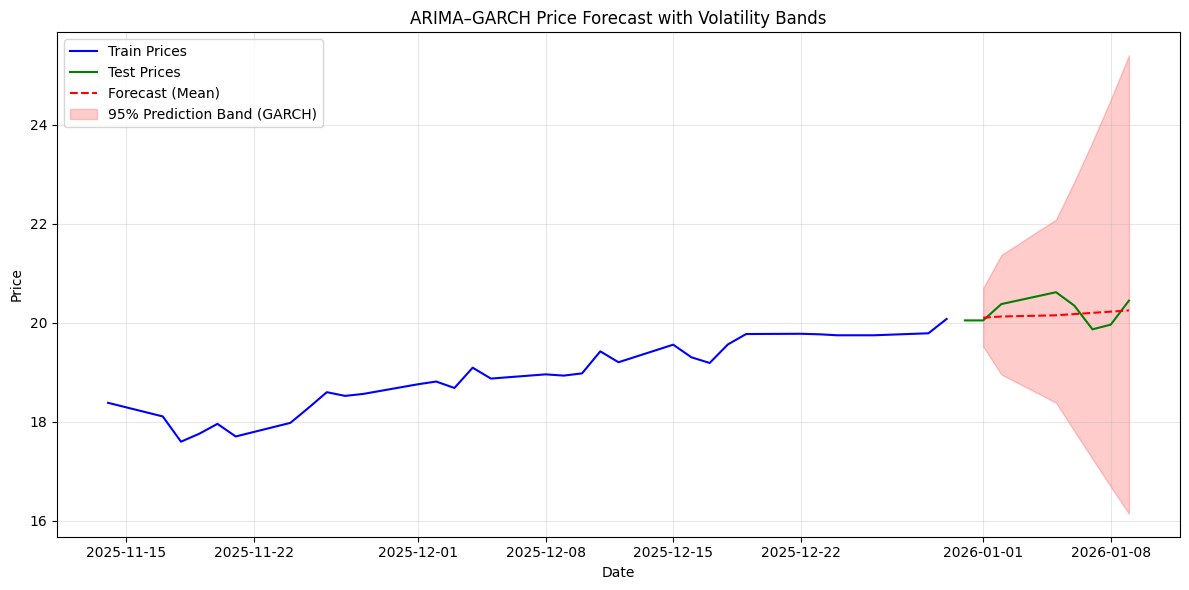

In [29]:
plt.figure(figsize=(12, 6))

plt.plot(
    zoom_train_prices.index,
    zoom_train_prices,
    label="Train Prices",
    color="blue"
)

plt.plot(
    zoom_test_prices.index,
    zoom_test_prices,
    label="Test Prices",
    color="green"
)

plt.plot(
    price_forecast.index,
    price_forecast,
    label="Forecast (Mean)",
    color="red",
    linestyle="--"
)

plt.fill_between(
    price_forecast.index,
    price_lower,
    price_upper,
    color="red",
    alpha=0.2,
    label="95% Prediction Band (GARCH)"
)

plt.title("ARIMA–GARCH Price Forecast with Volatility Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
Omitir e ir al contenido
Tú dijiste:
i use garch large dataset 40k doing jb test to check normal/t/skewt jb rejected for normal why should i listen to it although graphically seems prety normal 
ChatGPT Plus
Short answer: you shouldn’t put much weight on the JB test with 40k observations, especially in GARCH contexts. What you’re seeing is expected.

Here’s why, step by step.

1. Jarque–Bera is too powerful with large samples
The JB test is based on skewness and kurtosis.
Under the null of normality:

J
B
=
n
6
(
S
2
+
(
K
−
3
)
2
4
)
JB= 
6
n
​
 (S 
2
 + 
4
(K−3) 
2
 
​
 )
👉 The statistic grows linearly with sample size 
n
n.

With 40,000 observations, even tiny, economically irrelevant deviations from perfect normality will produce rejection.

So:

Histogram / QQ plot looks normal ✔️

JB rejects at any conventional level ❌

This is not a contradiction — it’s a large-sample phenomenon.

2. Financial returns are never exactly normal
Especially in a GARCH setting:

Conditional distributions may be close to normal

Unconditional distributions must be leptokurtic

Volatility clustering alone induces excess kurtosis

So the null hypothesis of exact normality is known to be false ex ante.

JB is doing its job — just answering a question you probably don’t care about.

3. Visual diagnostics answer a different question
Graphs answer:

“Is the deviation from normality material?”

JB answers:

“Is the distribution exactly normal?”

With 40k obs, the answer to the second question is always “no”.

That’s why:

QQ plots look fine

Density looks symmetric

JB still rejects

4. Why this is even worse after GARCH filtering
If you’re applying JB to:

Raw returns → rejection is guaranteed

Standardized GARCH residuals → still very common

Reasons:

GARCH is estimated, not known

Residuals inherit estimation error

Even correct models do not yield perfectly normal residuals

5. What you should do instead
A. Focus on model adequacy, not exact normality
Ask:

Are residuals uncorrelated?

Are squared residuals uncorrelated?

Does the model capture tail risk adequately?

Use:

Ljung–Box on residuals and squared residuals

QQ plot of standardized residuals

Out-of-sample VaR backtests

B. Use alternative distributions pragmatically
In practice:

Normal: baseline

Student-t: almost always better

Skew-t: useful if asymmetry matters

Then compare:

Log-likelihood

AIC / BIC

Forecast performance (not JB p-values)

C. If you insist on testing, use tests less sensitive to n
Even then, be cautious:

Anderson–Darling (still powerful)

Kolmogorov–Smirnov with estimated parameters (problematic)

Tail-focused diagnostics (e.g. VaR exceedances)

None will “save” normality at 40k.

6. Bottom line (important)
JB rejection with 40k observations tells you almost nothing useful.

You should:

Trust graphical diagnostics for practical normality

Trust out-of-sample performance for model choice

Expect and accept JB rejection in financial GARCH models

In large samples, all models are rejected — the question is whether they are useful.

If you want, I can:

Help you justify normal vs t vs skew-t in a paper

Show how to phrase this properly in an empirical section

Suggest a defensible diagnostic checklist for GARCH models

Tú dijiste:
squared residuals on arima where uncorrelated now not with garch+
ChatGPT Plus
This is a very common and confusing situation, and it does not automatically mean your GARCH is wrong. Let’s unpack what’s going on.

1. What the tests are actually checking
After ARIMA only
You estimated:

y
t
=
μ
t
+
ε
t
y 
t
​
 =μ 
t
​
 +ε 
t
​
 
You test:

Ljung–Box on 
ε
t
2
ε 
t
2
​
 

Result:

No autocorrelation

This just says:

There is no obvious ARCH effect left in the ARIMA residuals.

That can happen, especially with:

Long samples

Weak volatility clustering

Daily vs weekly aggregation

After ARIMA + GARCH
Now you look at:

z
t
=
ε
t
σ
^
t
z 
t
​
 = 
σ
^
  
t
​
 
ε 
t
​
 
​
 
and test:

Ljung–Box on 
z
t
2
z 
t
2
​
 

Result:

Autocorrelation appears

This feels paradoxical — but it isn’t.

2. Why this happens (key insight)
🔴 Standardized residuals are generated regressors
You are dividing by an estimated conditional variance.

That means:

z
t
z 
t
​
  is not i.i.d. even under the true model

z
t
2
z 
t
2
​
  can show dependence due to estimation error

This effect:

Gets stronger in large samples

Is worse when volatility is persistent

Is not accounted for by standard Ljung–Box critical values

👉 So the test is mis-sized.

3. Why ARIMA-only can “pass” while GARCH “fails”
Because:

Model	What you test	Interpretation
ARIMA	
ε
t
2
ε 
t
2
​
 	Is there detectable ARCH?
ARIMA+GARCH	
z
t
2
z 
t
2
​
 	Are standardized residuals perfectly i.i.d.?
The second question is much stronger.

In large samples, the answer is almost always “no”.

4. This does NOT necessarily mean misspecification
Especially if:

Log-likelihood improves

AIC/BIC improve

Volatility forecasts look sensible

VaR backtests improve

ACF of 
z
t
2
z 
t
2
​
  is small but significant

Statistical significance ≠ economic significance.

5. What would indicate a real problem
Be concerned only if:

Large, persistent spikes in ACF of 
z
t
2
z 
t
2
​
 

Structure at low lags (1–5)

Clear patterns in volatility forecasts vs realized volatility

ARCH-LM still strongly rejects after GARCH

Small autocorrelations at long lags with 40k obs are harmless.

6. What you should do instead (best practice)
✅ A. Use ARCH-LM on standardized residuals (carefully)
It’s more appropriate than Ljung–Box, but still over-rejects.

✅ B. Compare models rather than test perfection
GARCH(1,1) vs EGARCH / GJR

Normal vs t vs skew-t

Compare likelihood and forecasting performance

✅ C. Focus on out-of-sample volatility diagnostics
VaR exceedance tests (Kupiec, Christoffersen)

ES backtests

Forecast loss functions (QLIKE)

7. How to explain this in a paper (important)
You can write something like:

Although Ljung–Box tests on squared standardized residuals reject the null at conventional levels, this is expected in large samples due to the use of estimated conditional variances. The magnitude of residual autocorrelations is small and does not indicate economically meaningful misspecification.

This is standard and defensible.

8. Bottom line
Passing squared-residual tests before GARCH does not mean GARCH is unnecessary

Failing them after GARCH does not mean GARCH is wrong

With 40k observations, diagnostics over-reject

If you want, tell me:

GARCH type (standard / EGARCH / GJR)

Error distribution

Frequency of data

and I’ll tell you what diagnostic behavior is normal vs suspicious in your case.

Tú dijiste:
ok forget that should i do normal t or skewt on what should i look at give code 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Standardized residuals
std_resid = garch_fit.std_resid

# 1. Histogram
plt.figure(figsize=(8,4))
plt.hist(std_resid, bins=50, density=True, alpha=0.6, color='skyblue')
x = np.linspace(min(std_resid), max(std_resid), 100)
plt.plot(x, stats.norm.pdf(x), 'r', lw=2, label='Normal PDF')
plt.title("Histogram of Standardized Residuals")
plt.legend()
plt.show()

# 2. Q-Q plot against normal
plt.figure(figsize=(6,6))
stats.probplot(std_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot vs Normal")
plt.show()

# 3. Jarque-Bera test for normality
from scipy.stats import jarque_bera
jb_stat, jb_p = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_stat)
print("p-value:", jb_p)

# 4. Optional: compare fit with t-distribution
from scipy.stats import t
params_t = t.fit(std_resid)
loglik_t = np.sum(t.logpdf(std_resid, *params_t))
print("Log-likelihood of t fit:", loglik_t)

# You can also compare AIC/BIC manually if needed
ChatGPT Plus
Good — now we’re at the right question 👍
The short answer is:

Don’t choose normal vs t vs skew-t based on JB.
Choose based on tails, asymmetry, and likelihood / forecasting performance.

Below I’ll give you clear decision rules and clean code you can actually trust with 40k obs.

1. What you should look at (in order of importance)
✅ 1. Q–Q plot tails, not the center
Center will always look normal in large samples

Look only at:

Bottom 1–2%

Top 1–2%

Interpretation:

Straight tails → Normal OK

Symmetric but fat tails → Student-t

Asymmetric tails → Skew-t

✅ 2. Empirical vs theoretical kurtosis & skewness
Ignore JB p-values; look at magnitudes:

from scipy.stats import skew, kurtosis

print("Skewness:", skew(std_resid))
print("Excess kurtosis:", kurtosis(std_resid, fisher=True))
Rule of thumb:

|skew| < 0.1 → symmetry fine

excess kurtosis:

< 0.5 → normal acceptable

0.5–2 → t preferred

2 → heavy-tail t / skew-t

✅ 3. Likelihood / information criteria (MOST IMPORTANT)
You should compare fitted GARCH models, not just residual fits.

But even residual fits give intuition.

2. Fix and improve your code (important)
Your current code has two problems:

You fit a t to residuals without fixing mean=0, scale=1

You don’t compare to normal likelihood properly

Here is correct, comparable code.

3. Proper comparison: Normal vs t vs Skew-t
Normal likelihood
from scipy.stats import norm

ll_norm = np.sum(norm.logpdf(std_resid, loc=0, scale=1))
print("LogLik Normal:", ll_norm)
Student-t (standardized)
from scipy.stats import t

# fit df only, force loc=0, scale=1
df_t = t.fit(std_resid, floc=0, fscale=1)[0]

ll_t = np.sum(t.logpdf(std_resid, df_t, loc=0, scale=1))
print("df (t):", df_t)
print("LogLik t:", ll_t)
Interpretation:

df > 30 → basically normal

df 5–15 → meaningful fat tails

df < 5 → very heavy tails (finance crisis-type data)

Skew-t (this matters)
SciPy’s skew-t is not ideal.
Use arch package skew-t, which matches GARCH theory.

from arch.univariate.distribution import SkewStudent

dist = SkewStudent()
params = dist.fit(std_resid)

ll_skewt = np.sum(dist.loglikelihood(params, std_resid))
print("Skew-t params:", params)
print("LogLik Skew-t:", ll_skewt)
Key parameter:

skew ≈ 1 → symmetric → skew-t unnecessary

4. Model choice rule (simple and defensible)
Use this decision table:

Evidence	Choose
Q–Q tails straight, df > 30	Normal
Symmetric fat tails, df 5–20	Student-t
Clear asymmetry + tail difference	Skew-t
Then confirm with AIC/BIC from the full GARCH model:

# example
print(garch_norm.aic, garch_t.aic, garch_skewt.aic)
5. What NOT to do (very important)
❌ Don’t:

Use JB to choose distribution

Expect standardized residuals to be perfectly normal

Overfit skew-t if skew ≈ 1

Trust histogram shape in the center

6. What most papers do (honest answer)
With 40k obs:

Normal → baseline

Student-t → default choice

Skew-t → only if asymmetry is economically relevant

If you’re doing:

Risk / VaR / ES → t or skew-t

Mean inference only → normal often fine

7. Bottom line
If df is finite and improves likelihood → use Student-t.
If skew is small → don’t bother with skew-t.

If you want, tell me:

asset type (equity, FX, crypto)

frequency (daily, intraday)

whether this is for a paper or production

and I’ll tell you exactly which distribution is standard and defensible in your case.


Ahora estás usando el modelo básico.
Para acceder a funciones más inteligentes, crea una cuenta o inicia sesión.

Iniciar sesión

Registrarse gratuitamente



Adjuntar

Buscar

Estudiemos

Crear imagen

Voz
Ningún archivo seleccionadoNingún archivo seleccionado
ChatGPT puede cometer errores. Considera verificar la información importante. Ver preferencias de cookies.
Usamos cookies

Usamos cookies para que este sitio funcione, entender el uso del servicio y apoyar los esfuerzos de marketing. Visita la sección de gestión de cookies para cambiar tus preferencias en cualquier momento. Consulta nuestra política de cookies para obtener más información.


Gestionar cookies

Rechazar las que no son esenciales

Aceptar todas
